# Model Comparison Notebook

Compare performance of different model checkpoints side-by-side.

In [10]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import cv2

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) if 'notebooks' in os.getcwd() else os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from models.yolo_like import Model
from datasets.target_encoding import load_yolo_labels
from datasets.transforms import letterbox_image
from eval.evaluator import ObjectDetectionEvaluator, evaluate_predictions

print("All imports successful!")

All imports successful!


In [11]:
# Helper functions for evaluation (from scripts/evaluate.py)

def decode_predictions(pred_grid, conf_thresh=0.5, grid_size=26, img_size=416):
    """Decode grid predictions [S, S, 5] to bounding boxes."""
    S = grid_size
    boxes = []

    for j in range(S):
        for i in range(S):
            tx = pred_grid[j, i, 0].item()
            ty = pred_grid[j, i, 1].item()
            tw = pred_grid[j, i, 2].item()
            th = pred_grid[j, i, 3].item()
            obj_conf = pred_grid[j, i, 4].item()

            if obj_conf < conf_thresh:
                continue

            cx = (i + tx) / S
            cy = (j + ty) / S
            w = tw
            h = th

            cx_pix = cx * img_size
            cy_pix = cy * img_size
            w_pix = w * img_size
            h_pix = h * img_size

            x1 = cx_pix - w_pix / 2
            y1 = cy_pix - h_pix / 2
            x2 = cx_pix + w_pix / 2
            y2 = cy_pix + h_pix / 2

            boxes.append((x1, y1, x2, y2, obj_conf))

    return boxes


def compute_iou(box1, box2):
    """Compute IoU between two boxes (x1, y1, x2, y2, conf)."""
    x1_1, y1_1, x2_1, y2_1, _ = box1
    x1_2, y1_2, x2_2, y2_2, _ = box2

    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)

    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0

    inter_area = (x2_i - x1_i) * (y2_i - y1_i)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0.0


def nms(boxes, iou_thresh=0.5):
    """Apply Non-Maximum Suppression."""
    if len(boxes) == 0:
        return []

    boxes = sorted(boxes, key=lambda x: x[4], reverse=True)
    keep = []

    while len(boxes) > 0:
        best = boxes[0]
        keep.append(best)
        boxes = boxes[1:]

        filtered = []
        for box in boxes:
            iou = compute_iou(best, box)
            if iou < iou_thresh:
                filtered.append(box)
        boxes = filtered

    return keep


def infer_image(model, image_path, device, img_size=416, grid_size=26,
                conf_thresh=0.5, iou_thresh=0.5):
    """Run inference on a single image."""
    img_tensor, params = letterbox_image(image_path, (img_size, img_size))
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_tensor)

    boxes = decode_predictions(pred[0], conf_thresh, grid_size, img_size)
    boxes = nms(boxes, iou_thresh)

    return boxes, params


def transform_boxes_to_original(boxes, params, img_size=416):
    """Transform boxes from letterbox coordinates to original image coordinates."""
    if len(boxes) == 0:
        return []

    scale = params['scale']
    pad_w = params['pad_w']
    pad_h = params['pad_h']
    orig_w, orig_h = params['orig_wh']

    transformed = []
    for (x1, y1, x2, y2, conf) in boxes:
        x1_no_pad = x1 - pad_w
        y1_no_pad = y1 - pad_h
        x2_no_pad = x2 - pad_w
        y2_no_pad = y2 - pad_h

        x1_orig = x1_no_pad / scale
        y1_orig = y1_no_pad / scale
        x2_orig = x2_no_pad / scale
        y2_orig = y2_no_pad / scale

        x1_orig = max(0, min(x1_orig, orig_w))
        y1_orig = max(0, min(y1_orig, orig_h))
        x2_orig = max(0, min(x2_orig, orig_w))
        y2_orig = max(0, min(y2_orig, orig_h))

        transformed.append((x1_orig, y1_orig, x2_orig, y2_orig, conf))

    return transformed


def evaluate_dataset(model, image_dir, label_dir, device, img_size=416,
                    grid_size=26, conf_thresh=0.5, iou_thresh=0.5,
                    max_images=None):
    """Evaluate model on all images in a directory."""
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))

    if max_images:
        image_paths = image_paths[:max_images]

    all_predictions = []
    all_ground_truth = []
    image_ids = []
    stats = {
        'total': 0,
        'processed': 0,
        'errors': 0,
        'images_with_objects': 0,
        'total_pred_objects': 0,
        'total_gt_objects': 0,
    }

    print(f"\nEvaluating {len(image_paths)} images...")
    print("-" * 70)

    for idx, img_path in enumerate(image_paths):
        stats['total'] += 1

        try:
            basename = os.path.basename(img_path)
            label_name = os.path.splitext(basename)[0] + '.txt'
            label_path = os.path.join(label_dir, label_name)

            gt_boxes = load_yolo_labels(label_path)
            if len(gt_boxes) > 0:
                stats['images_with_objects'] += 1
            stats['total_gt_objects'] += len(gt_boxes)

            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            gt_pixel = []
            for (cx, cy, bw, bh) in gt_boxes:
                x1 = (cx - bw / 2) * w
                y1 = (cy - bh / 2) * h
                x2 = (cx + bw / 2) * w
                y2 = (cy + bh / 2) * h
                gt_pixel.append((x1, y1, x2, y2))

            preds, params = infer_image(
                model, img_path, device, img_size, grid_size,
                conf_thresh, iou_thresh
            )

            preds_orig = transform_boxes_to_original(preds, params, img_size)

            all_predictions.append(preds_orig)
            all_ground_truth.append(gt_pixel)
            image_ids.append(basename)

            stats['processed'] += 1
            stats['total_pred_objects'] += len(preds_orig)

            if (idx + 1) % 50 == 0:
                print(f"Processed {idx + 1}/{len(image_paths)} images...")

        except Exception as e:
            stats['errors'] += 1
            print(f"Error processing {img_path}: {e}")

    print("-" * 70)
    print(f"Evaluation complete: {stats['processed']} images processed, {stats['errors']} errors")

    return all_predictions, all_ground_truth, image_ids, stats

print("Helper functions loaded!")

Helper functions loaded!


## Configuration

In [12]:
# Dataset paths
VAL_IMAGES = "data/processed_training_3/images/val"
VAL_LABELS = "data/processed_training_3/labels/val"

# Model configuration
GRID_SIZE = 26
IMG_SIZE = 416
NUM_CLASSES = 1

# Evaluation parameters
CONF_THRESHOLD = 0.5
NMS_THRESHOLD = 0.5
IOU_THRESHOLDS = [0.5, 0.75]

# Device
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: mps


## Model Comparison Class

In [13]:
class ModelEvaluator:
    """Evaluate and compare different model checkpoints."""
    
    def __init__(self, checkpoint_path, name, device='cpu'):
        """
        Args:
            checkpoint_path: Path to model checkpoint
            name: Descriptive name for this model
            device: Device to run evaluation on
        """
        self.checkpoint_path = checkpoint_path
        self.name = name
        self.device = device
        self.results = None
        self.checkpoint = None
        
        # Load checkpoint info
        self._load_checkpoint_info()
    
    def _load_checkpoint_info(self):
        """Load checkpoint metadata."""
        try:
            self.checkpoint = torch.load(self.checkpoint_path, map_location='cpu')
            self.val_loss = self.checkpoint.get('val_loss', 'N/A')
            self.epoch = self.checkpoint.get('epoch', 'N/A')
            self.train_losses = self.checkpoint.get('train_losses', [])
            self.val_losses = self.checkpoint.get('val_losses', [])
        except Exception as e:
            print(f"Error loading checkpoint {self.checkpoint_path}: {e}")
            self.val_loss = 'Error'
            self.epoch = 'Error'
            self.train_losses = []
            self.val_losses = []
    
    def evaluate(self, image_dir, label_dir, conf_thresh=0.5, nms_thresh=0.5, iou_thresholds=[0.5, 0.75]):
        """Run evaluation on validation set."""
        print(f"\nEvaluating {self.name}...")
        print(f"Checkpoint: {self.checkpoint_path}")
        print(f"Training - Epoch: {self.epoch}, Val Loss: {self.val_loss}")
        
        # Initialize model
        model = Model(S=GRID_SIZE)
        
        # Load weights
        if self.checkpoint is not None:
            model.load_state_dict(self.checkpoint['model'])
        model.to(self.device)
        model.eval()
        
        # Run evaluation using evaluate_dataset function
        all_preds, all_gt, image_ids, stats = evaluate_dataset(
            model, image_dir, label_dir, self.device,
            grid_size=GRID_SIZE, img_size=IMG_SIZE,
            conf_thresh=conf_thresh, iou_thresh=nms_thresh
        )
        
        # Compute metrics using evaluate_predictions
        eval_results = evaluate_predictions(
            all_preds, all_gt,
            iou_thresholds=iou_thresholds,
            verbose=False
        )
        
        # Compute mAP
        evaluator = ObjectDetectionEvaluator(iou_thresholds)
        map_scores = evaluator.compute_map(all_preds, all_gt)
        
        # Store results - eval_results is a dict of EvaluationMetrics objects
        self.results = {}
        for iou_thresh in iou_thresholds:
            iou_key = f'iou_{iou_thresh}'
            metrics = eval_results[iou_thresh]  # This is an EvaluationMetrics object
            self.results[iou_key] = {
                'precision': metrics.precision,
                'recall': metrics.recall,
                'f1': metrics.f1,
                'tp': metrics.tp,
                'fp': metrics.fp,
                'fn': metrics.fn,
                'ap': map_scores[iou_thresh]
            }
        
        self.stats = stats
        return self.results
    
    def print_summary(self):
        """Print evaluation summary."""
        if self.results is None:
            print(f"No results available for {self.name}")
            return
        
        print(f"\n{'='*70}")
        print(f"{self.name} - EVALUATION SUMMARY")
        print(f"{'='*70}")
        print(f"Checkpoint: {self.checkpoint_path}")
        print(f"Epoch: {self.epoch}, Val Loss: {self.val_loss:.4f}" if isinstance(self.val_loss, (int, float)) else f"Epoch: {self.epoch}, Val Loss: {self.val_loss}")
        print()
        
        for key, metrics in self.results.items():
            iou_val = key.replace('iou_', '')
            print(f"IoU Threshold: {iou_val}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall:    {metrics['recall']:.4f}")
            print(f"  F1 Score:  {metrics['f1']:.4f}")
            print(f"  mAP:       {metrics['ap']:.4f}")
            print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
            print()
    
    def get_metric(self, metric_name, iou_threshold=0.5):
        """Get specific metric value."""
        if self.results is None:
            return None
        key = f'iou_{iou_threshold}'
        if key in self.results:
            return self.results[key].get(metric_name, None)
        return None

## Load Validation Dataset

In [14]:
# No need to load dataset separately - ModelEvaluator handles it
print(f"Dataset paths configured:"
      f"  Images: {VAL_IMAGES}")
print(f"  Labels: {VAL_LABELS}")

Dataset paths configured:  Images: data/processed_training_3/images/val
  Labels: data/processed_training_3/labels/val


## Define Models to Compare

In [15]:
# Define models to compare
models = [
    ModelEvaluator(
        checkpoint_path="checkpoints/best_epoch50_lambda5.pt",
        name="OLD MODEL (λ_coord=5.0, no augmentation)",
        device=DEVICE
    ),
    ModelEvaluator(
        checkpoint_path="checkpoints/best.pt",
        name="NEW MODEL (λ_coord=10.0, with augmentation)",
        device=DEVICE
    ),
]

print(f"Loaded {len(models)} models for comparison")

Loaded 2 models for comparison


/var/folders/r3/xkc526kx16b79w1jm5bg9xr80000gn/T/ipykernel_98417/3116219832.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.checkpoint = torch.load(self.checkpoint

In [ ]:
# YOLOv5 Evaluator Class
class YOLOv5Evaluator:
    """Evaluate YOLOv5 model for comparison."""
    
    def __init__(self, model_name='yolov5s', name='YOLOv5', device='cpu'):
        """
        Args:
            model_name: YOLOv5 model variant (yolov5n, yolov5s, yolov5m, yolov5l, yolov5x)
            name: Descriptive name for this model
            device: Device to run evaluation on
        """
        self.model_name = model_name
        self.name = name
        self.device = device
        self.results = None
        self.model = None
        
    def _load_model(self):
        """Load YOLOv5 model."""
        try:
            import torch
            # Load YOLOv5 from torch hub
            self.model = torch.hub.load('ultralytics/yolov5', self.model_name, pretrained=True)
            self.model.to(self.device)
            self.model.eval()
            print(f"Loaded {self.model_name} from torch hub")
        except Exception as e:
            print(f"Error loading YOLOv5: {e}")
            print("Install YOLOv5 with: pip install ultralytics")
            self.model = None
    
    def evaluate(self, image_dir, label_dir, conf_thresh=0.5, nms_thresh=0.5, iou_thresholds=[0.5, 0.75]):
        """Run evaluation on validation set."""
        print(f"\nEvaluating {self.name}...")
        
        # Load model if not already loaded
        if self.model is None:
            self._load_model()
        
        if self.model is None:
            print("Skipping YOLOv5 evaluation (model not available)")
            return None
        
        # Set model parameters
        self.model.conf = conf_thresh
        self.model.iou = nms_thresh
        
        # Get image paths
        image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        
        all_predictions = []
        all_ground_truth = []
        
        print(f"Evaluating {len(image_paths)} images...")
        print("-" * 70)
        
        for idx, img_path in enumerate(image_paths):
            try:
                # Get label path
                basename = os.path.basename(img_path)
                label_name = os.path.splitext(basename)[0] + '.txt'
                label_path = os.path.join(label_dir, label_name)
                
                # Load ground truth
                gt_boxes = load_yolo_labels(label_path)
                
                # Convert GT to pixel coordinates
                img = cv2.imread(img_path)
                h, w = img.shape[:2]
                gt_pixel = []
                for (cx, cy, bw, bh) in gt_boxes:
                    x1 = (cx - bw / 2) * w
                    y1 = (cy - bh / 2) * h
                    x2 = (cx + bw / 2) * w
                    y2 = (cy + bh / 2) * h
                    gt_pixel.append((x1, y1, x2, y2))
                
                # Run YOLOv5 inference
                results = self.model(img_path)
                
                # Extract predictions for person class (class 0)
                preds = []
                detections = results.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2, conf, class]
                
                for det in detections:
                    x1, y1, x2, y2, conf, cls = det
                    if int(cls) == 0:  # Person class
                        preds.append((x1, y1, x2, y2, conf))
                
                all_predictions.append(preds)
                all_ground_truth.append(gt_pixel)
                
                if (idx + 1) % 50 == 0:
                    print(f"Processed {idx + 1}/{len(image_paths)} images...")
                    
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                all_predictions.append([])
                all_ground_truth.append([])
        
        print("-" * 70)
        print(f"Evaluation complete")
        
        # Compute metrics
        eval_results = evaluate_predictions(
            all_predictions, all_ground_truth,
            iou_thresholds=iou_thresholds,
            verbose=False
        )
        
        # Compute mAP
        evaluator = ObjectDetectionEvaluator(iou_thresholds)
        map_scores = evaluator.compute_map(all_predictions, all_ground_truth)
        
        # Store results
        self.results = {}
        for iou_thresh in iou_thresholds:
            iou_key = f'iou_{iou_thresh}'
            metrics = eval_results[iou_thresh]
            self.results[iou_key] = {
                'precision': metrics.precision,
                'recall': metrics.recall,
                'f1': metrics.f1,
                'tp': metrics.tp,
                'fp': metrics.fp,
                'fn': metrics.fn,
                'ap': map_scores[iou_thresh]
            }
        
        return self.results
    
    def print_summary(self):
        """Print evaluation summary."""
        if self.results is None:
            print(f"No results available for {self.name}")
            return
        
        print(f"\n{'='*70}")
        print(f"{self.name} - EVALUATION SUMMARY")
        print(f"{'='*70}")
        print(f"Model: {self.model_name}")
        print()
        
        for key, metrics in self.results.items():
            iou_val = key.replace('iou_', '')
            print(f"IoU Threshold: {iou_val}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall:    {metrics['recall']:.4f}")
            print(f"  F1 Score:  {metrics['f1']:.4f}")
            print(f"  mAP:       {metrics['ap']:.4f}")
            print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
            print()
    
    def get_metric(self, metric_name, iou_threshold=0.5):
        """Get specific metric value."""
        if self.results is None:
            return None
        key = f'iou_{iou_threshold}'
        if key in self.results:
            return self.results[key].get(metric_name, None)
        return None
    
    # Dummy attributes for compatibility with comparison code
    @property
    def epoch(self):
        return "N/A"
    
    @property
    def val_loss(self):
        return "N/A"
    
    @property
    def train_losses(self):
        return []
    
    @property
    def val_losses(self):
        return []

print("YOLOv5Evaluator class loaded!")

In [ ]:
# OPTIONAL: Add YOLOv5 to comparison
# Uncomment the lines below to include YOLOv5 in the comparison

# yolov5_model = YOLOv5Evaluator(
#     model_name='yolov5s',  # Options: yolov5n, yolov5s, yolov5m, yolov5l, yolov5x
#     name="YOLOv5s Baseline",
#     device=DEVICE
# )
# models.append(yolov5_model)
# print(f"Added YOLOv5 to comparison. Total models: {len(models)}")

print(f"Current models to compare: {len(models)}")

## Optional: Add YOLOv5 Baseline for Comparison

Run this cell if you want to compare against a pre-trained YOLOv5 model.

## Run Evaluation on All Models

In [16]:
# Evaluate all models
for model_eval in models:
    model_eval.evaluate(
        image_dir=VAL_IMAGES,
        label_dir=VAL_LABELS,
        conf_thresh=CONF_THRESHOLD,
        nms_thresh=NMS_THRESHOLD,
        iou_thresholds=IOU_THRESHOLDS
    )
    model_eval.print_summary()


Evaluating OLD MODEL (λ_coord=5.0, no augmentation)...
Checkpoint: checkpoints/best_epoch50_lambda5.pt
Training - Epoch: 8, Val Loss: 4.848957458767322

Evaluating 218 images...
----------------------------------------------------------------------
Processed 50/218 images...
Processed 100/218 images...
Processed 150/218 images...
Processed 200/218 images...
----------------------------------------------------------------------
Evaluation complete: 218 images processed, 0 errors

OLD MODEL (λ_coord=5.0, no augmentation) - EVALUATION SUMMARY
Checkpoint: checkpoints/best_epoch50_lambda5.pt
Epoch: 8, Val Loss: 4.8490

IoU Threshold: 0.5
  Precision: 0.6788
  Recall:    0.5193
  F1 Score:  0.5884
  mAP:       0.3870
  TP: 391, FP: 185, FN: 362

IoU Threshold: 0.75
  Precision: 0.1597
  Recall:    0.1222
  F1 Score:  0.1384
  mAP:       0.0384
  TP: 92, FP: 484, FN: 661


Evaluating NEW MODEL (λ_coord=10.0, with augmentation)...
Checkpoint: checkpoints/best.pt
Training - Epoch: 30, Val Loss

## Side-by-Side Comparison Table

In [17]:
import pandas as pd

def create_comparison_table(models, iou_threshold=0.5):
    """Create comparison table for all models."""
    
    data = []
    for model_eval in models:
        row = {
            'Model': model_eval.name,
            'Epoch': model_eval.epoch,
            'Val Loss': f"{model_eval.val_loss:.4f}" if isinstance(model_eval.val_loss, (int, float)) else model_eval.val_loss,
            'Precision': f"{model_eval.get_metric('precision', iou_threshold):.4f}",
            'Recall': f"{model_eval.get_metric('recall', iou_threshold):.4f}",
            'F1': f"{model_eval.get_metric('f1', iou_threshold):.4f}",
            'mAP': f"{model_eval.get_metric('ap', iou_threshold):.4f}",
            'TP': model_eval.get_metric('tp', iou_threshold),
            'FP': model_eval.get_metric('fp', iou_threshold),
            'FN': model_eval.get_metric('fn', iou_threshold),
        }
        data.append(row)
    
    df = pd.DataFrame(data)
    return df

# Create tables for different IoU thresholds
print("\n" + "="*100)
print("COMPARISON TABLE - IoU 0.5")
print("="*100)
df_05 = create_comparison_table(models, iou_threshold=0.5)
print(df_05.to_string(index=False))

print("\n" + "="*100)
print("COMPARISON TABLE - IoU 0.75")
print("="*100)
df_075 = create_comparison_table(models, iou_threshold=0.75)
print(df_075.to_string(index=False))


COMPARISON TABLE - IoU 0.5
                                      Model  Epoch Val Loss Precision Recall     F1    mAP  TP  FP  FN
   OLD MODEL (λ_coord=5.0, no augmentation)      8   4.8490    0.6788 0.5193 0.5884 0.3870 391 185 362
NEW MODEL (λ_coord=10.0, with augmentation)     30   4.7636    0.8250 0.7703 0.7967 0.6118 580 123 173

COMPARISON TABLE - IoU 0.75
                                      Model  Epoch Val Loss Precision Recall     F1    mAP  TP  FP  FN
   OLD MODEL (λ_coord=5.0, no augmentation)      8   4.8490    0.1597 0.1222 0.1384 0.0384  92 484 661
NEW MODEL (λ_coord=10.0, with augmentation)     30   4.7636    0.2945 0.2749 0.2843 0.0998 207 496 546


## Visual Comparison - Bar Charts

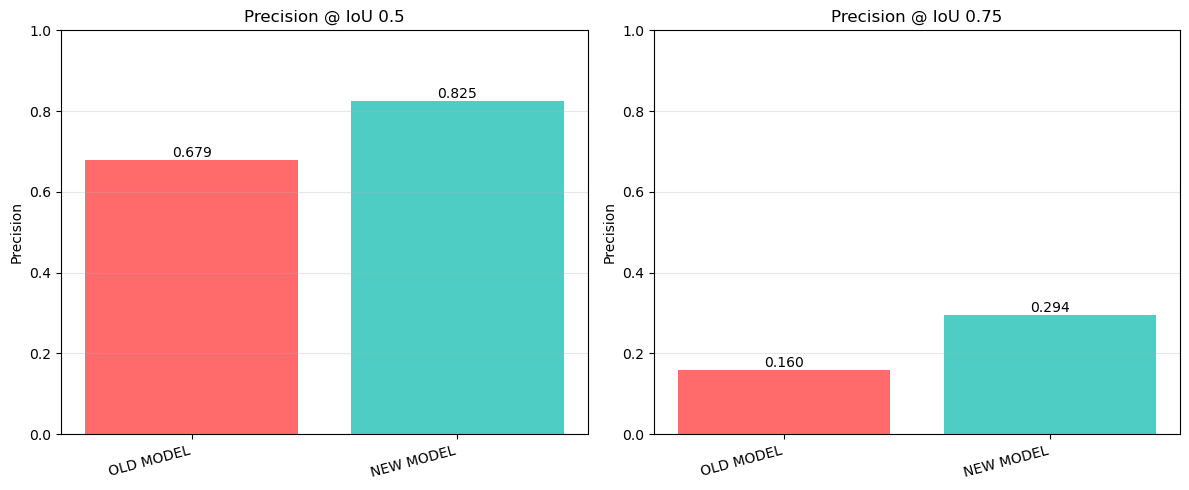

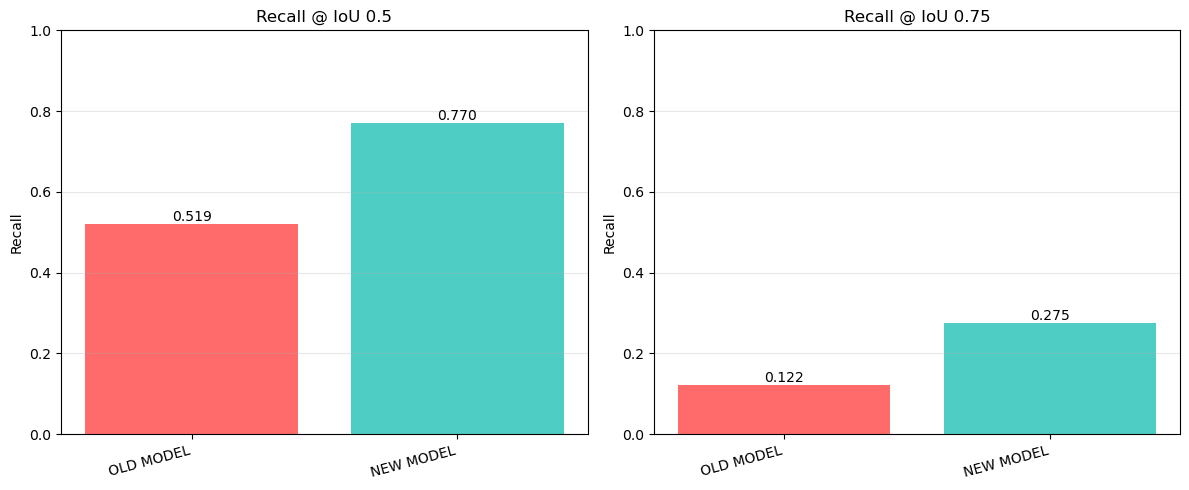

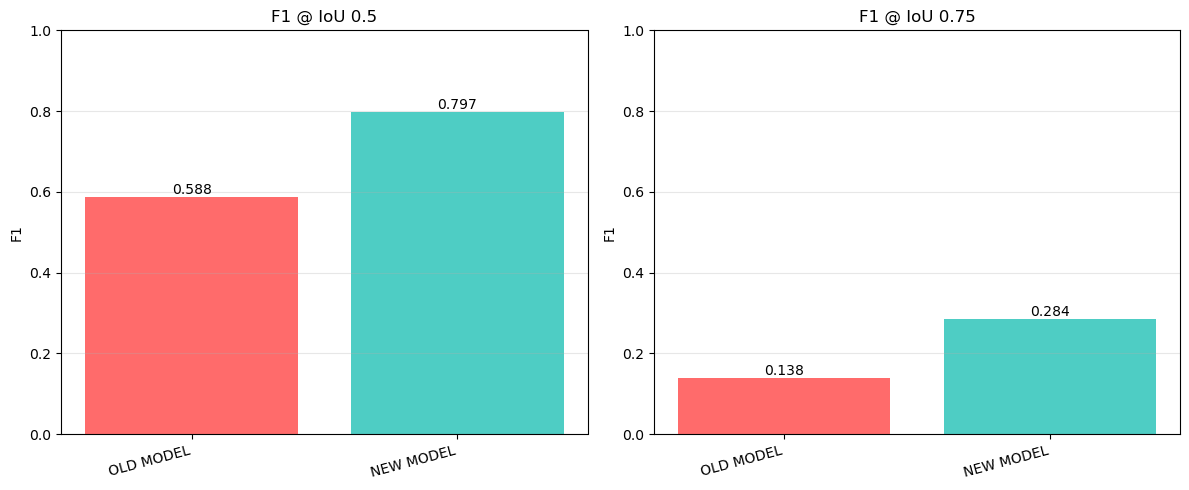

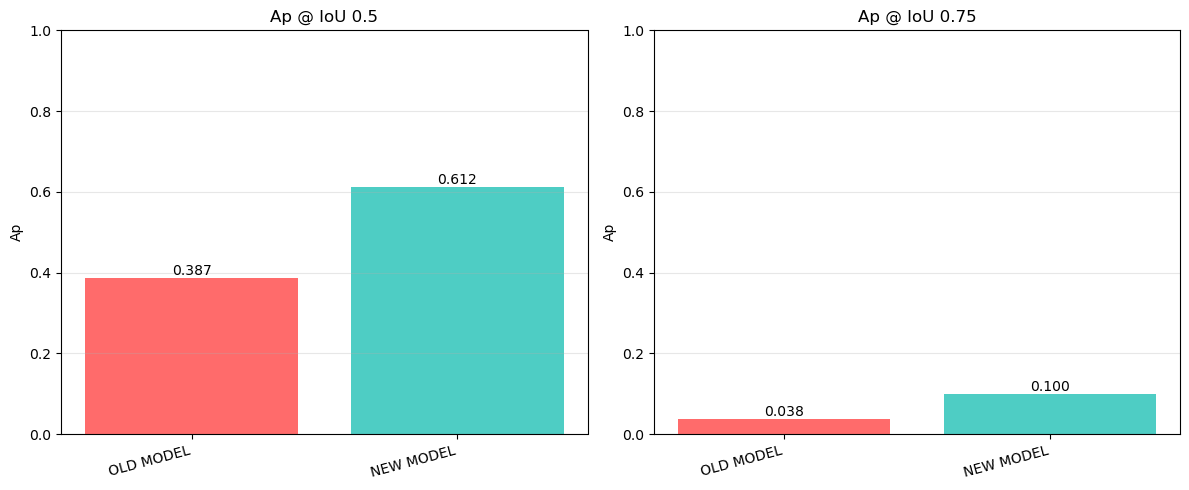

In [18]:
def plot_metric_comparison(models, metric_name, iou_thresholds=[0.5, 0.75]):
    """Plot bar chart comparing a specific metric across models."""
    
    fig, axes = plt.subplots(1, len(iou_thresholds), figsize=(6*len(iou_thresholds), 5))
    if len(iou_thresholds) == 1:
        axes = [axes]
    
    for idx, iou_thresh in enumerate(iou_thresholds):
        ax = axes[idx]
        
        model_names = [m.name.split('(')[0].strip() for m in models]
        values = [m.get_metric(metric_name, iou_thresh) for m in models]
        
        bars = ax.bar(range(len(models)), values, color=['#ff6b6b', '#4ecdc4'])
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(model_names, rotation=15, ha='right')
        ax.set_ylabel(metric_name.capitalize())
        ax.set_title(f'{metric_name.capitalize()} @ IoU {iou_thresh}')
        ax.set_ylim(0, 1.0 if metric_name != 'ap' else 1.0)
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, values)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Plot key metrics
metrics_to_plot = ['precision', 'recall', 'f1', 'ap']

for metric in metrics_to_plot:
    plot_metric_comparison(models, metric, iou_thresholds=IOU_THRESHOLDS)

## Training Loss Curves Comparison

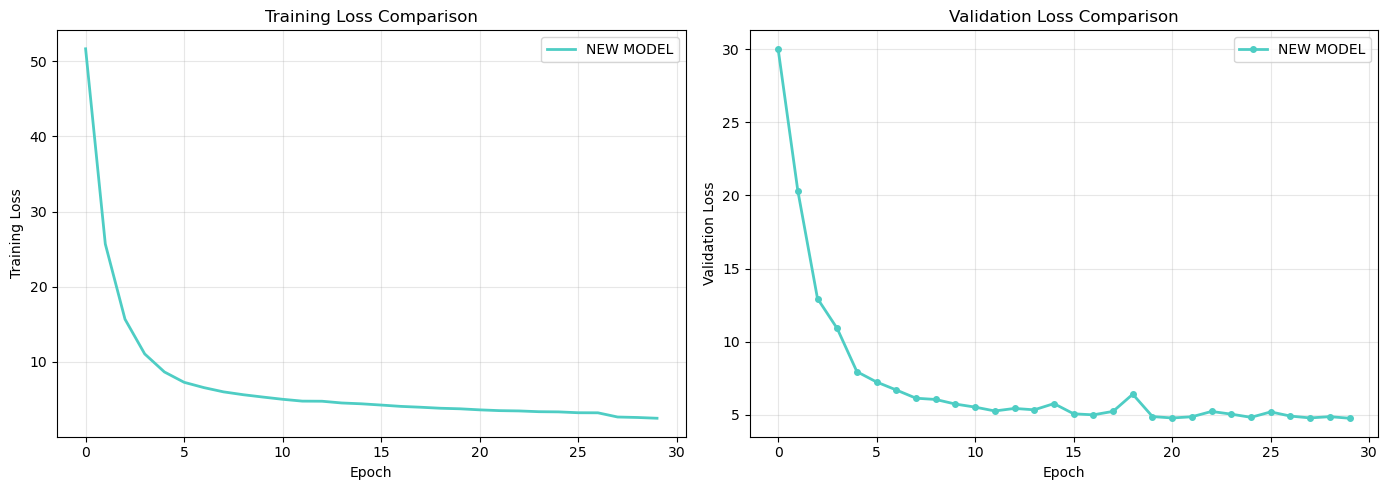

In [19]:
def plot_loss_comparison(models):
    """Plot training and validation loss curves for all models."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = ['#ff6b6b', '#4ecdc4', '#95e1d3', '#f38181']
    
    # Training loss
    for idx, model_eval in enumerate(models):
        if len(model_eval.train_losses) > 0:
            ax1.plot(model_eval.train_losses, 
                    label=model_eval.name.split('(')[0].strip(),
                    color=colors[idx % len(colors)],
                    linewidth=2)
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss Comparison')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Validation loss
    for idx, model_eval in enumerate(models):
        if len(model_eval.val_losses) > 0:
            ax2.plot(model_eval.val_losses,
                    label=model_eval.name.split('(')[0].strip(),
                    color=colors[idx % len(colors)],
                    linewidth=2,
                    marker='o',
                    markersize=4)
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss Comparison')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_loss_comparison(models)

## Improvement Analysis

In [20]:
def calculate_improvements(base_model, new_model, iou_threshold=0.5):
    """Calculate percentage improvements from base to new model."""
    
    metrics = ['precision', 'recall', 'f1', 'ap']
    improvements = {}
    
    print(f"\nIMPROVEMENTS @ IoU {iou_threshold}")
    print("="*70)
    print(f"Comparing: {base_model.name} → {new_model.name}")
    print("="*70)
    
    for metric in metrics:
        base_val = base_model.get_metric(metric, iou_threshold)
        new_val = new_model.get_metric(metric, iou_threshold)
        
        if base_val is not None and new_val is not None and base_val > 0:
            improvement = ((new_val - base_val) / base_val) * 100
            improvements[metric] = improvement
            
            print(f"{metric.upper():12s}: {base_val:.4f} → {new_val:.4f} ({improvement:+.1f}%)")
    
    return improvements

# Calculate improvements for both IoU thresholds
if len(models) >= 2:
    for iou_thresh in IOU_THRESHOLDS:
        improvements = calculate_improvements(models[0], models[1], iou_threshold=iou_thresh)
        print()


IMPROVEMENTS @ IoU 0.5
Comparing: OLD MODEL (λ_coord=5.0, no augmentation) → NEW MODEL (λ_coord=10.0, with augmentation)
PRECISION   : 0.6788 → 0.8250 (+21.5%)
RECALL      : 0.5193 → 0.7703 (+48.3%)
F1          : 0.5884 → 0.7967 (+35.4%)
AP          : 0.3870 → 0.6118 (+58.1%)


IMPROVEMENTS @ IoU 0.75
Comparing: OLD MODEL (λ_coord=5.0, no augmentation) → NEW MODEL (λ_coord=10.0, with augmentation)
PRECISION   : 0.1597 → 0.2945 (+84.4%)
RECALL      : 0.1222 → 0.2749 (+125.0%)
F1          : 0.1384 → 0.2843 (+105.4%)
AP          : 0.0384 → 0.0998 (+159.7%)



## Summary Statistics

In [21]:
print("\n" + "="*70)
print("OVERALL SUMMARY")
print("="*70)

for model_eval in models:
    print(f"\n{model_eval.name}")
    print("-" * 70)
    print(f"  Training: Epoch {model_eval.epoch}, Val Loss: {model_eval.val_loss}")
    print(f"  Best Performance (IoU 0.5):")
    print(f"    - mAP: {model_eval.get_metric('ap', 0.5):.4f}")
    print(f"    - F1:  {model_eval.get_metric('f1', 0.5):.4f}")
    print(f"  Best Performance (IoU 0.75):")
    print(f"    - mAP: {model_eval.get_metric('ap', 0.75):.4f}")
    print(f"    - F1:  {model_eval.get_metric('f1', 0.75):.4f}")


OVERALL SUMMARY

OLD MODEL (λ_coord=5.0, no augmentation)
----------------------------------------------------------------------
  Training: Epoch 8, Val Loss: 4.848957458767322
  Best Performance (IoU 0.5):
    - mAP: 0.3870
    - F1:  0.5884
  Best Performance (IoU 0.75):
    - mAP: 0.0384
    - F1:  0.1384

NEW MODEL (λ_coord=10.0, with augmentation)
----------------------------------------------------------------------
  Training: Epoch 30, Val Loss: 4.763634991276701
  Best Performance (IoU 0.5):
    - mAP: 0.6118
    - F1:  0.7967
  Best Performance (IoU 0.75):
    - mAP: 0.0998
    - F1:  0.2843
